# **Image Repair and Restoration Using   Selfattention Convolutional Autoencoder**

## Importing Necessary Libraries

In [ ]:
import tensorflow as tf                                                                                                # Library for deep learning operations
import numpy as np                                                                                                     # Numerical operations
import matplotlib.pyplot as plt                                                                                        # Plotting

from keras.models import Model                                                                                         # Defining models
import os, cv2                                                                                                         # File and image operations
import matplotlib.image as mpimg                                                                                       # Module from Matplotlib for image loading
from pylab import rcParams                                                                                             # Import rcParams module from pylab for setting figure size
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle                                                                                       # Data shuffling
from sklearn.model_selection import train_test_split                                                                    # Splitting data
import pandas as pd                                                                                                     # Data manipulation
from IPython.display import display, Image                                                                              # Displaying images
from keras.preprocessing.image import load_img                                                                          # Loading images

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau                                           # Callback functions for model training
from keras.models import load_model                                                                                     # Loading pre-trained models
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model                                                                           # Visualizing models
from keras.preprocessing.image import ImageDataGenerator                                                                # Data augmentation
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dense, UpSampling2D,Dropout         # Layers for building neural networks

from skimage.metrics import structural_similarity as ssim                                                               # Image quality assessment
from skimage.metrics import peak_signal_noise_ratio as psnr                                                             # Image quality assessment
from google.colab import drive                                                                                          # Importing the drive module from the google.colab library

In [ ]:
# Mount Google Drive to the Colab environment
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the dataset directory path
dataset_dir = '/content/drive/MyDrive/fer35'

# Extract Data from CSV

In [ ]:
names=['emotion','pixels','usage']                                                              # Specify the different features names
df=pd.read_csv('/content/drive/MyDrive/fer35/fer2013.csv',names=names, na_filter=False)
im=df['pixels']                                                                                 # Extract the 'pixels' column from the DataFrame
df.shape                                                                                        # Get the shape of the DataFrame

(35888, 3)

In [ ]:
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [ ]:
filname='/content/drive/MyDrive/fer35/fer2013.csv'

## Adding labels and images(pixel values) in respective array

In [ ]:
 # images are 48x48
def getData(filename):
    Y = []                          # List to store labels
    X = []                          # List to store pixel values
    first = True
    max_length = 0  # Track the maximum length of sublists

    for line in open(filename):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            pixel_values = [int(p) for p in row[1].split()]
            X.append(pixel_values)
            max_length = max(max_length, len(pixel_values))

    # Pad shorter sublists with zeros to match the maximum length
    X_padded = [x + [0]*(max_length - len(x)) for x in X]

    X, Y = np.array(X_padded), np.array(Y)       # Convert lists to numpy arrays
    return X, Y


In [ ]:
X, Y = getData(filname)                    # Extracting data from the dataset file using the getData function
num_class = len(set(Y))                    # Calculate the number of unique classes in the dataset
print(num_class)                           # Print the number of unique classes

7


## Reshaping images

In [ ]:
# keras with tensorflow backend
N, D = X.shape

#reshaping the dataset
X = X.reshape(N, 48, 48, 1)


# Extracting Data and splitting train and test

In [ ]:
#splitting data in train, test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

# Print the number of samples in the training and testing sets
print("Number of samples in x_train:", x_train.shape)
print("Number of samples in x_test:", x_test.shape[0])
print("Number of samples in y_train:", y_train.shape[0])
print("Number of samples in y_test:", y_test.shape[0])

Number of samples in x_train: (28709, 48, 48, 1)
Number of samples in x_test: 7178
Number of samples in y_train: 28709
Number of samples in y_test: 7178


In [ ]:
x_train.shape

(28709, 48, 48, 1)

In [ ]:
x_test.shape

(7178, 48, 48, 1)

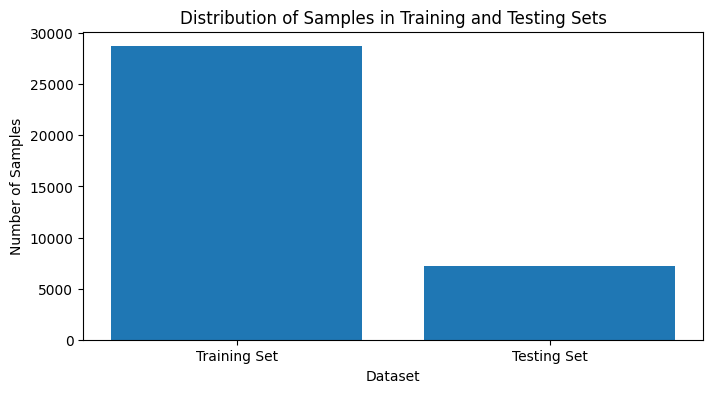

In [ ]:
plt.figure(figsize=(8, 4))
# Define the labels for the bars
labels = ['Training Set', 'Testing Set']

# Define the number of samples in each set
samples = [x_train.shape[0], x_test.shape[0]]

# Create a bar plot
plt.bar(labels, samples)

# Add title and labels
plt.title('Distribution of Samples in Training and Testing Sets')
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')

# Show the plot
plt.show()

In [ ]:
#Taking 5000 images

# x_train = x_train[:10000]
# # x_test = x_test[:5000]

# x_trains = x_train[:10000]
# x_test = x_test[:5000]


In [ ]:


# # Assuming y_train and y_test contain the labels for training and testing data respectively
# unique_train_labels, train_label_counts = np.unique(y_train, return_counts=True)
# unique_test_labels, test_label_counts = np.unique(y_test, return_counts=True)

# # Plotting
# plt.figure(figsize=(10, 5))
# plt.bar(unique_train_labels, train_label_counts, width=0.4, align='center', label='Training')
# plt.bar(unique_test_labels + 0.4, test_label_counts, width=0.4, align='center', label='Testing')
# plt.xlabel('Labels')
# plt.ylabel('Count')
# plt.title('Training and Testing Label Counts')
# plt.xticks(unique_train_labels + 0.2, unique_train_labels)  # Align x-ticks with bars
# plt.legend()
# plt.show()

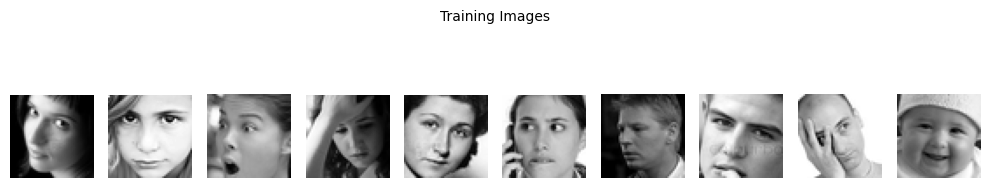

In [ ]:
import random

# Number of random images to display
num_images = 10

# Get random indices for the training set
random_training_indices = random.sample(range(len(x_train)), num_images)

# Get random indices for the testing set
# random_testing_indices = random.sample(range(len(x_test)), num_images)

# Plot random images from the training set
plt.figure(figsize=(10,4))
for i, index in enumerate(random_training_indices, 1):
    plt.subplot(2, num_images, i)
    plt.imshow(x_train[index].reshape(48, 48), cmap='gray')
    # plt.title(f'Training Image {i}')
    plt.suptitle('Training Images', fontsize=10)
    plt.axis('off')

# # Plot random images from the testing set
# for i, index in enumerate(random_testing_indices, 1):
#     plt.subplot(2, num_images, i + num_images)
#     plt.imshow(x_test[index].reshape(48, 48), cmap='gray')
#     plt.suptitle('Testing Images', fontsize=16)
#     # plt.title(f'Testing Image {i}')
#     plt.axis('off')

plt.tight_layout()
plt.show()


#**Data Preprocessing**

In [ ]:
#NOrmalizing the images
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

#reshaping the images
x_train = np.reshape(x_train, (len(x_train), 48, 48, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 48, 48, 1))     # adapt this if using `channels_first` image data format


#adding noise in data
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

#clipping put data near to 0--->0 aand data near to 1-->1(eg=0.3-->0 or 0.7-->1)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Visualization of 10 Data

In [ ]:
n = 10

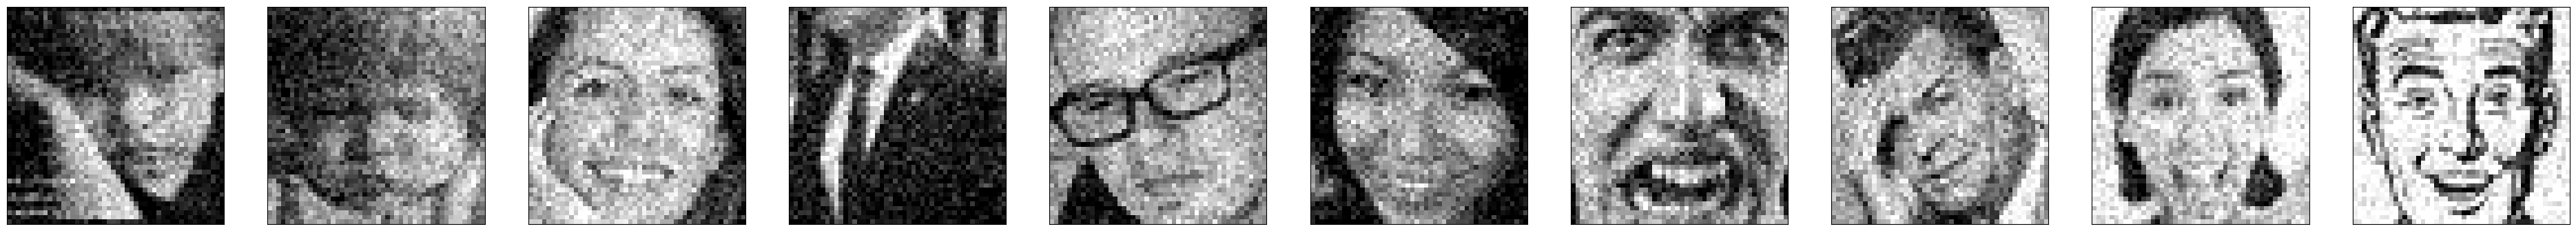

In [ ]:
plt.figure(figsize=(48, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_train_noisy[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

 **Self-Attention CAE Model**

In [ ]:
from keras.layers import Layer, Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Concatenate, Reshape, Dense, Add
from keras.models import Model
import keras.backend as K

class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.theta = Dense(self.channels // 8, use_bias=False)
        self.phi = Dense(self.channels // 8, use_bias=False)
        self.g = Dense(self.channels // 2, use_bias=False)
        self.sigma = Dense(self.channels, use_bias=False)
        super(SelfAttention, self).build(input_shape)

    def call(self, x):
        theta = self.theta(x)
        phi = self.phi(x)
        g = self.g(x)

        theta = Reshape((-1, self.channels // 8))(theta)
        phi = Reshape((-1, self.channels // 8))(phi)
        g = Reshape((-1, self.channels // 2))(g)

        theta_phi = K.batch_dot(theta, phi, axes=[2, 2])
        attention_weights = K.softmax(theta_phi)

        attention = K.batch_dot(attention_weights, g, axes=[2, 1])
        attention = Reshape((K.int_shape(x)[1], K.int_shape(x)[2], self.channels // 2))(attention)

        sigma = self.sigma(attention)
        return x * sigma

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def upconv_block(input_tensor, skip_tensor, num_filters):
    x = UpSampling2D((2, 2))(input_tensor)
    x = Concatenate()([x, skip_tensor])
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

input_img = Input(shape=(48, 48, 1))

# Encoder
conv1 = conv_block(input_img, 64)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1)

conv2 = conv_block(pool1, 128)
pool2 = MaxPooling2D((2, 2), padding='same')(conv2)

# Bottleneck with Self-Attention
conv3 = conv_block(pool2, 256)
self_attention = SelfAttention()(conv3)
bottleneck = Add()([conv3, self_attention])  # Add skip connection

# Decoder
upconv4 = upconv_block(bottleneck, conv2, 128)
upconv5 = upconv_block(upconv4, conv1, 64)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(upconv5)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 64)           640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 48, 48, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 48, 48, 64)           0         ['batch_normalization[0][0

**Architecture of  Self-Attention CAE**

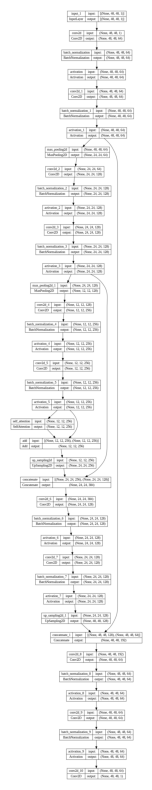

In [ ]:
# Draw the architecture of the autoencoder
plot_model(autoencoder, to_file='autoencoder_architecture.png', show_shapes=True)

# Display the architecture image
img = mpimg.imread('autoencoder_architecture.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=30,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/30
449/449 [==============================] - 63s 107ms/step - loss: 0.0033 - val_loss: 0.0159
Epoch 2/30
449/449 [==============================] - 45s 101ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 3/30
449/449 [==============================] - 46s 103ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 4/30
449/449 [==============================] - 47s 104ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/30
449/449 [==============================] - 48s 108ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 6/30
449/449 [==============================] - 47s 104ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 7/30
449/449 [==============================] - 47s 104ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 8/30
449/449 [==============================] - 47s 104ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 9/30
449/449 [==============================] - 47s 104ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 10/30
449/449 [==============================] - 48s 108ms/step - l

Mean Squared Error

In [ ]:
# Print the MSE value
print("Mean Squared Error (MSE):", history.history['loss'][-1])

Mean Squared Error (MSE): 0.0017078699311241508


In [ ]:
predict = autoencoder.predict(x_test_noisy)

225/225 [==============================] - 5s 15ms/step


# Visualizing the prediction







## Original Test images

In [ ]:
n=10

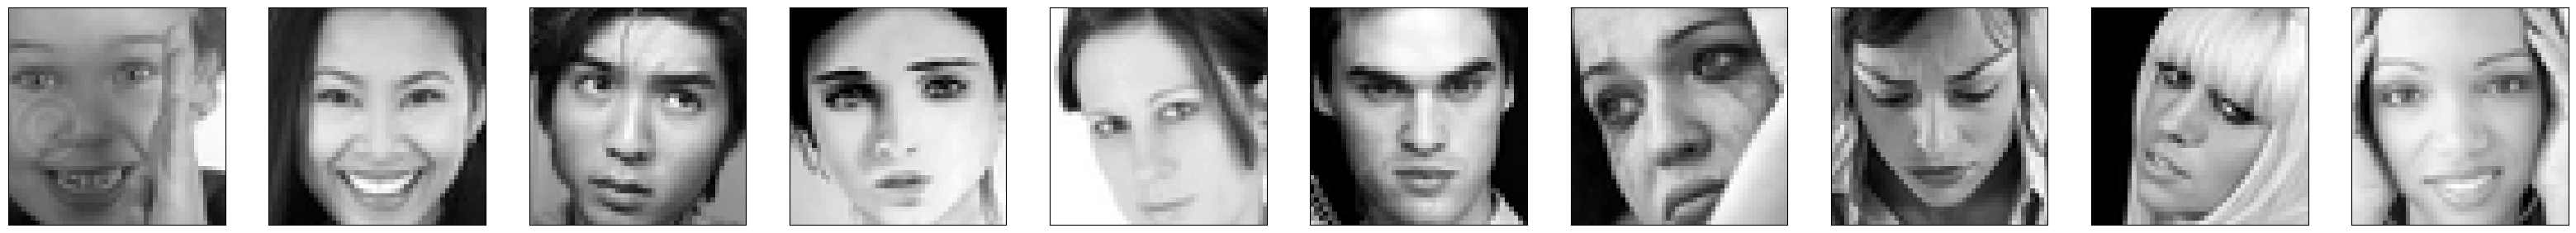

In [ ]:
plt.figure(figsize=(40, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Noised Test images

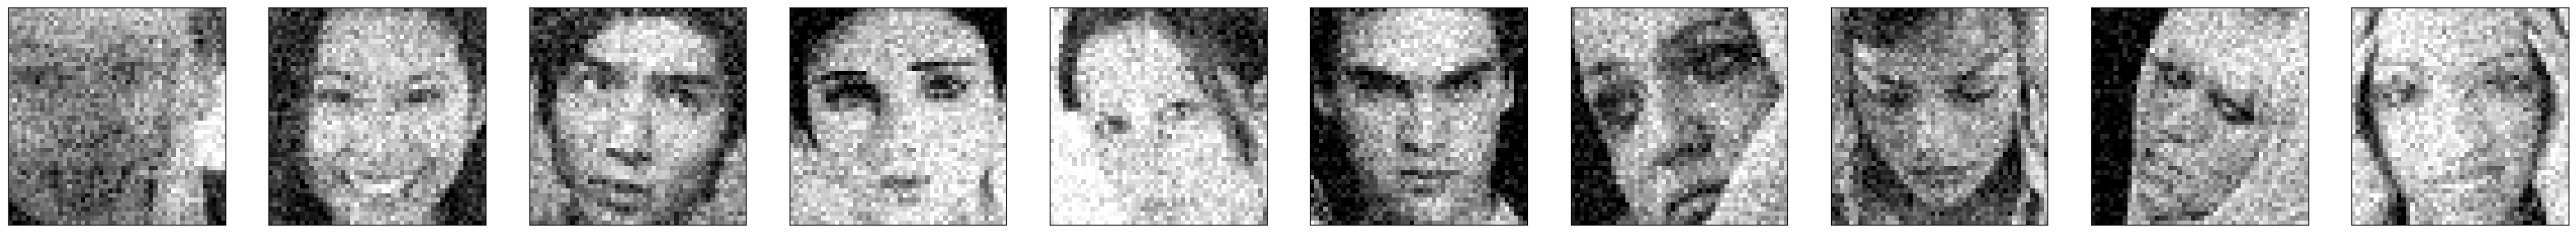

In [ ]:
plt.figure(figsize=(40, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Generated Test images

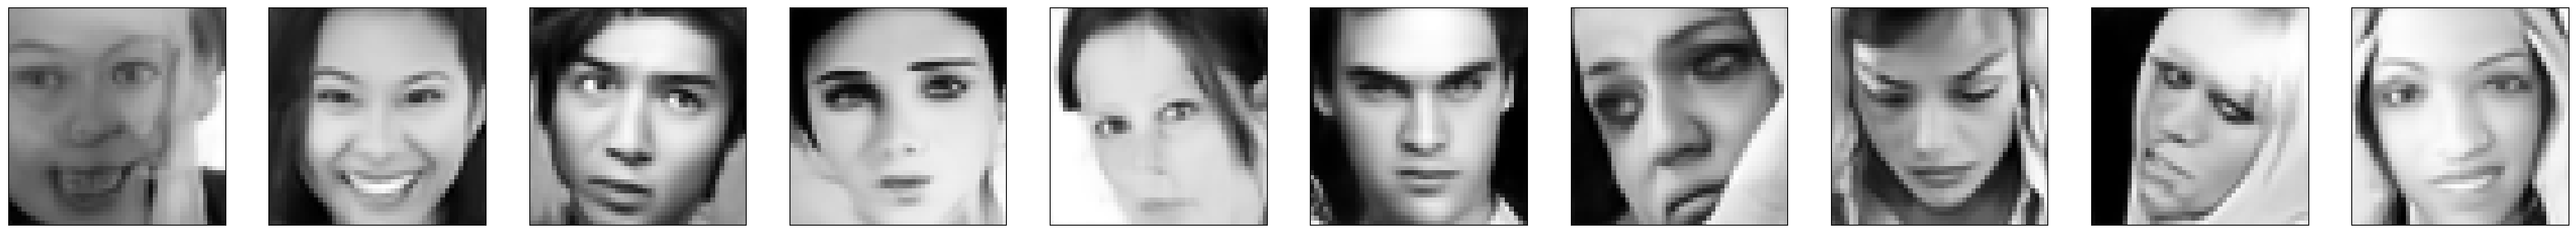

In [ ]:
plt.figure(figsize=(40, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(predict[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

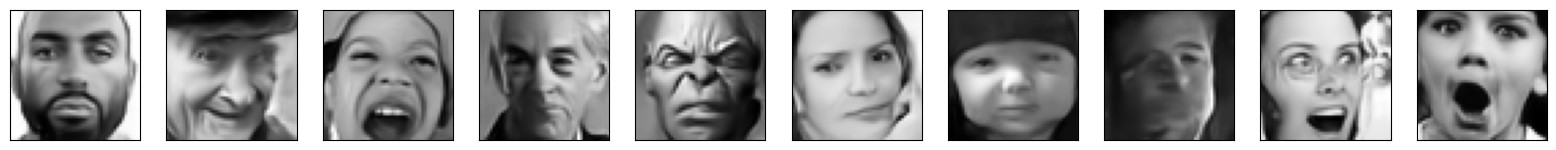

In [ ]:
n=20
plt.figure(figsize=(40, 48))
for i in range(10,n,1):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(predict[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Train Loss VS validation loss

In [ ]:
# print(autoencoder.history.history.keys())

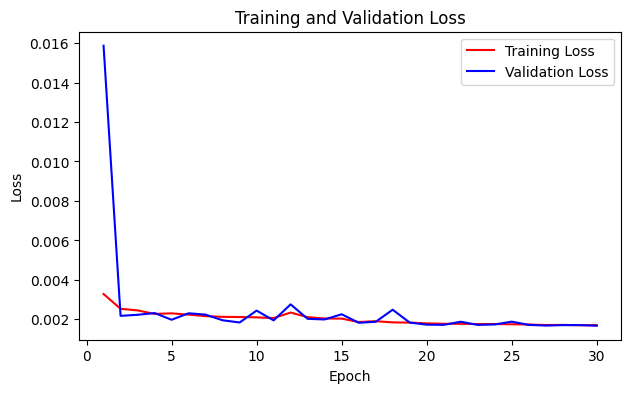

In [ ]:
plt.figure(figsize=(7, 4))
# Accessing training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting training and validation losses
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<ipython-input-32-91dea0012bc9>:11: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(x_test[i], predict[i], multichannel=True)


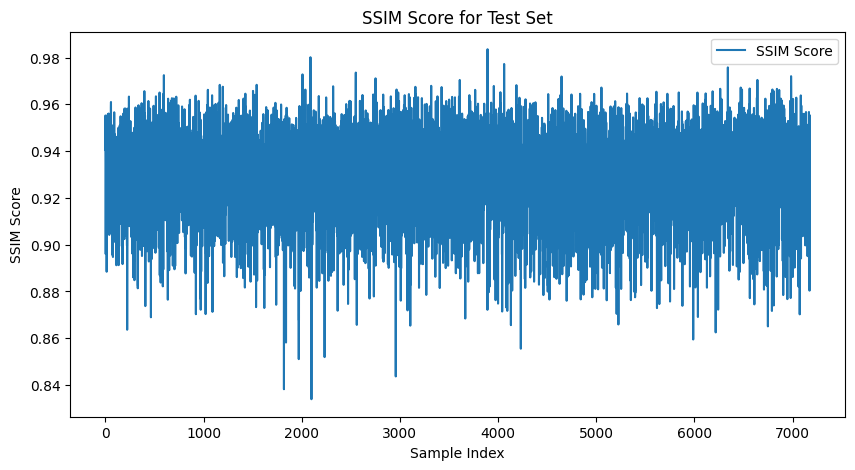

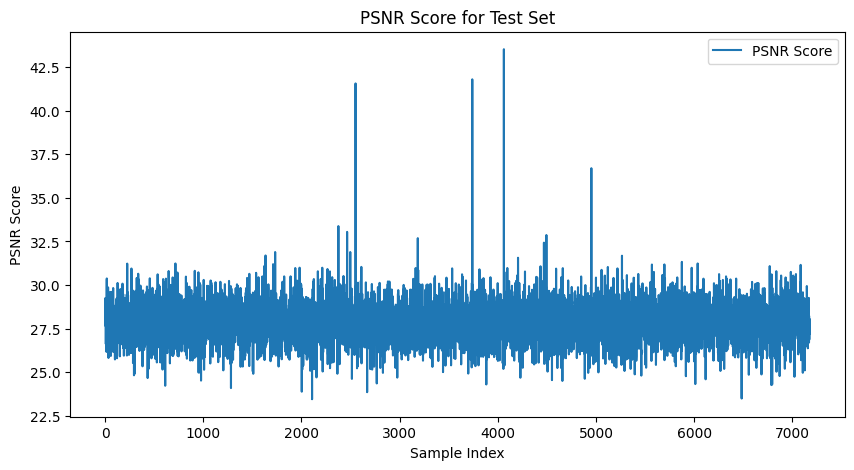

In [ ]:
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Initialize lists to store SSIM and PSNR scores
ssim_scores = []
psnr_scores = []

# Calculate SSIM and PSNR scores for each sample in the test set
for i in range(len(x_test)):
    ssim_score = ssim(x_test[i], predict[i], multichannel=True)
    psnr_score = psnr(x_test[i], predict[i])
    ssim_scores.append(ssim_score)
    psnr_scores.append(psnr_score)

# Plot SSIM scores
plt.figure(figsize=(10, 5))
plt.plot(ssim_scores, label='SSIM Score')
plt.xlabel('Sample Index')
plt.ylabel('SSIM Score')
plt.title('SSIM Score for Test Set')
plt.legend()
plt.show()

# Plot PSNR scores
plt.figure(figsize=(10, 5))
plt.plot(psnr_scores, label='PSNR Score')
plt.xlabel('Sample Index')
plt.ylabel('PSNR Score')
plt.title('PSNR Score for Test Set')
plt.legend()
plt.show()


**Calculate SSIM and PSNR**

In [ ]:
# Calculate SSIM and PSNR
ssim_score = ssim(x_test, predict, multichannel=True)
psnr_score = psnr(x_test, predict)

print("SSIM Score:", ssim_score)
print("PSNR Score:", psnr_score)

<ipython-input-33-97b45d55fe1f>:2: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(x_test, predict, multichannel=True)


SSIM Score: 0.98116094
PSNR Score: 27.751607237475472


In [ ]:
# Calculate PSNR between noisy and test images
psnr_value = psnr(x_test, x_test_noisy)
# Calculate SSIM between noisy and test images
ssim_value = ssim(x_test_noisy, x_test, multichannel=True)
# Print the PSNR value
print("PSNR between noisy and test images:", psnr_value)
# Print the SSIM value
print("SSIM between noisy and test images:", ssim_value)

<ipython-input-34-b383a80c7217>:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = psnr(x_test, x_test_noisy)
<ipython-input-34-b383a80c7217>:4: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(x_test_noisy, x_test, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


PSNR between noisy and test images: 20.316906025965388
SSIM between noisy and test images: 0.9049726238513726


**Save the model**

In [ ]:
# Save the model
autoencoder.save('/content/drive/MyDrive/fer35/autoencoder_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model

# Define custom objects for loading the model
custom_objects = {'SelfAttention': SelfAttention}

# Load the saved model with custom objects
loaded_model = load_model("/content/drive/MyDrive/fer35/autoencoder_model.h5", custom_objects=custom_objects)

